[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/TomGeorge1234/HelmholtzHippocampus/blob/main/figs12.ipynb)
# Figures 3 & 4 
This code replicates core results from figures 3, 4.

<img src="./images/nf3.png" width=400>

<img src="./images/nf4.png" width=400>


## 0 Install and import dependencies

In [2]:
# Install RatInABox whih is a python package we use for simulating this neural data
!pip install wget ratinabox==1.6.3 tomplotlib==1.2.2 

In [34]:
#Import HH_utils (where all the project code is) and ratinabox
#downloads the utils functions 
import os
if os.path.exists("HH_utils.py"): pass
else: wget.download("https://github.com/TomGeorge1234/HelmholtzHippocampus/raw/main/HH_utils.py"); print("...utils downloaded!")
from HH_utils import (PyramidalNeurons, 
                      run_simulation,
                      run_pathint_test,
                      align_matrix)


from ratinabox.Environment import Environment
from ratinabox.Agent import Agent
from ratinabox.Neurons import FeedForwardLayer, PlaceCells, VelocityCells

import numpy as np
import tomplotlib as tpl #plot formatting and saving things
import copy
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
experiment = 'normal'

if experiment == 'normal':
    experiment_params = {
        'mec_to_cvc':'identity',
        'place_cells_to_hpc':'identity',
        'hpc_to_mec':'random',
        'save_name':'normal',
    }

# if experiment == 'random_hpc':
#     experiment_params = {
#         'mec_to_cvc':'identity',
#         'place_cells_to_hpc':'random',
#         'hpc_to_mec':'random',
#         'save_name':'random_hpc',
#     }

# if experiment == 'random_cvcs':
#     experiment_params = {
#         'mec_to_cvc':'random',
#         'place_cells_to_hpc':'identity',
#         'hpc_to_mec':'random',
#         'save_name':'random_cvcs',
#     }

if experiment == 'remapping':
    experiment_params = {
        'mec_to_cvc':'identity',
        'place_cells_to_hpc':'identity',
        'hpc_to_mec':'identity',
        'save_name':'remapping',
    }

# if experiment == 'remapping_random':
#     experiment_params = {
#         'mec_to_cvc':'identity',
#         'place_cells_to_hpc':'identity',
#         'hpc_to_mec':'random',
#         'save_name':'remapping',
#     }

## 1 Construct the basic architecture 

In [36]:
# Global constants 
THETA_FREQ = 5         # theta frequency 
ENV_SIZE = 1           # size of the environment
SPEED_MEAN = 0         # mean of the speed of the agent
SPEED_STD = 0.5        # standard deviation of the speed of the agent
THETA_FUNC = 'square'  # theta shape
INPUT_WIDTH = 0.06     # width of the place cell inputs
TAU = 1                # timescale of the latent variables
N = 100                # number of neurons in the hidden layers
ETA = 0.01            # learning rate
TAU_PI = 100e-3        # timescale of the discrepancy error 
L2 = 0.005             # L2 regularization strength on MEC apical inputs 
DT = 25e-3             # simulation timestep

#Make the environment and agent
Env = Environment(params={'boundary_conditions':'periodic','dimensionality':'1D','scale':ENV_SIZE})
Ag = Agent(Env, params={'dt':DT,'speed_mean':SPEED_MEAN,'speed_std':SPEED_STD}) 


#Make the neurons
Features = PlaceCells(Ag,
        params={  
        'description':'gaussian', 
        'n':N,
        'name':'Features',
        'color':'C4',
        'widths':INPUT_WIDTH,
    })

HPC = PyramidalNeurons(Ag,
        params={
        'name':'HPC',
        'theta_func':THETA_FUNC,
        'theta_freq':THETA_FREQ,
        'n':N,
        'color':'C2',
        'dendrite_activation_params':{'activation':'linear'},
        })

EC = PyramidalNeurons(Ag,
        params={
        'name':'EC',
        'theta_func':THETA_FUNC,
        'theta_freq':THETA_FREQ,
        'n':N,
        'color':'C0',
        'dendrite_activation_params':{'activation':'retanh'}
        })

VCs = VelocityCells(Ag,params={'name':'VCs'})
CVCs = FeedForwardLayer(Ag,
                    params={'n':2*N,
                            'name':'CVCs',
                                'activation_params':{
                                        "activation": "relu",
                                        "threshold":1.0, #<--- seems important to see scale of grid activity
                                        }
                                })

/Users/tomgeorge/miniconda3/envs/HHH/lib/python3.11/site-packages/ratinabox/Neurons.py:1766: UserWarning: No input layers have been provided. Either hand them in in the params dictionary params['input_layers']=[list,of,inputs] or use self.add_input_layer() to add them manually.
  warnings.warn(


### 1.1 Connect all the neurons together 
as per figure 3a and b

In [37]:
# Conjunction of velocity and MEC inputs
CVCs.add_input(VCs)
CVCs.add_input(EC)
CVCs.inputs['VCs']['w'] = np.concatenate([np.ones((N,2))*np.array([1,-1]),
                                           np.ones((N,2))*np.array([-1,1])])
CVCs.inputs['EC']['w']  = np.vstack([np.eye(N),np.eye(N)])

# HPC gets basal input from features and apical input from EC 
HPC.basal_compartment.add_input(Features,eta=0,w_init=1.5)
HPC.basal_compartment.inputs['Features']['w'] = np.identity(HPC.n)
HPC.apical_compartment.add_input(EC,eta=ETA,w_init=1,bias=True)

# EC gets basal input from HPC and apical input from CVCs and itself
EC.basal_compartment.add_input(HPC,eta=ETA,w_init=1,bias=True)
EC.apical_compartment.add_input(EC,eta=ETA,w_init=0.2,bias=False)
EC.apical_compartment.add_input(CVCs,eta=ETA,w_init=0.2,bias=False)

layers = [Features,HPC,EC,CVCs,VCs]

## 2 Train the network 

<Loss> = [('HPC', '4.82e-02'), ('EC', '2.39e-02')]: 100%|██████████| 72000/72000 [06:26<00:00, 186.19it/s]


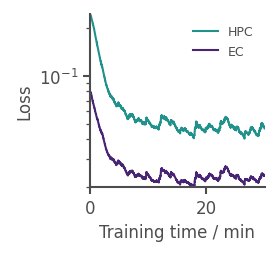

In [38]:
layers = [Features,HPC,EC,CVCs,VCs]
train_mins = 30
fig, ax = run_simulation(time_min=train_mins,Agent=Ag,layers=layers,train=True)
Ag.t_finished_training = Ag.t

## 3 Test the model 

### 3.1 Run a path integration test. 

`run_pathint_test()` Takes in the network and a decoding layer and trains a decoder to read out position from the decoding layer's activity (based on previously collected data). Then, it runs the network for a short period in oscillitory mode before swithing it to generatvie mode effectively lesioning the real sensory inputs from the network. The network is then run for a long period in generative mode and the decoder is used to read out the position. The position is then compared to the true position to calculate the error.

100%|██████████| 1/1 [00:04<00:00,  4.28s/it]


(1200,) (1200,) (1200,)
Figure saved to /Users/tomgeorge/Documents/UCL/HelmholtzHippocampus/NeurIPS_code/figures/13_12_23/pathint_1633.png  & .svg
Figure saved to /Users/tomgeorge/Documents/UCL/HelmholtzHippocampus/NeurIPS_code/figures/13_12_23/decoding_1633.png  & .svg
Figure saved to /Users/tomgeorge/Documents/UCL/HelmholtzHippocampus/NeurIPS_code/figures/13_12_23/error_1633.png  & .svg


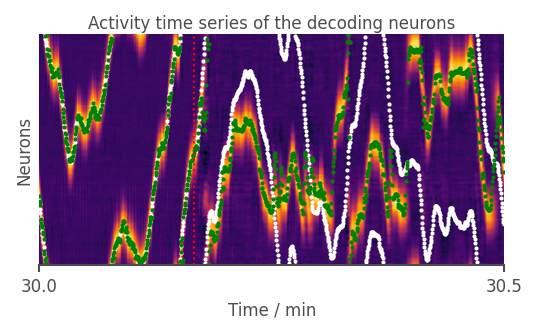

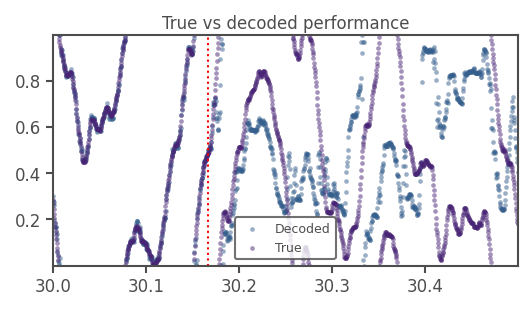

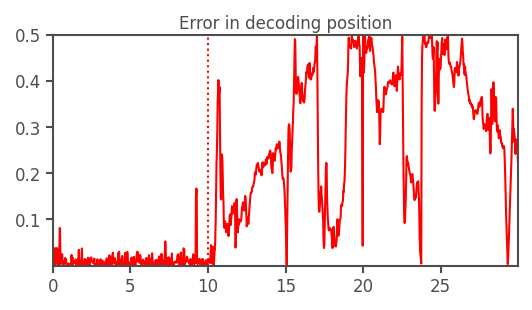

In [39]:
t, errors= run_pathint_test(layers,
                            HPC,
                            test_secs = 20,
                            n_tests=1)

### 3.2 Revealing bump attractor

The plan here is to view the population activity, representations and weights in HPC and (more importantly MEC) and then reorder everything by MEC receptive field peak activity. After reordering we should hopefully see the bump attractor in MEC. 

#### 3.2.1 Visualise the population activity before reordering
You should see that hippocampal activity is structured -- this is because its representations are constrained by the order place cell sensory inouts coming from the environment -- whereas MEC activity is unstructured -- because the representations were not constrained, we'll see structure after reordering. 

Figure saved to /Users/tomgeorge/Documents/UCL/HelmholtzHippocampus/NeurIPS_code/figures/13_12_23/HPC_firingrate_1633.png  & .svg
Figure saved to /Users/tomgeorge/Documents/UCL/HelmholtzHippocampus/NeurIPS_code/figures/13_12_23/HPC_ratemaps_1633.png  & .svg
Figure saved to /Users/tomgeorge/Documents/UCL/HelmholtzHippocampus/NeurIPS_code/figures/13_12_23/EC_firingrate_1633.png  & .svg
Figure saved to /Users/tomgeorge/Documents/UCL/HelmholtzHippocampus/NeurIPS_code/figures/13_12_23/EC_ratemaps_1633.png  & .svg


(<Figure size 600x240 with 1 Axes>,
 <Axes: xlabel='Position / m', ylabel='Neurons'>)

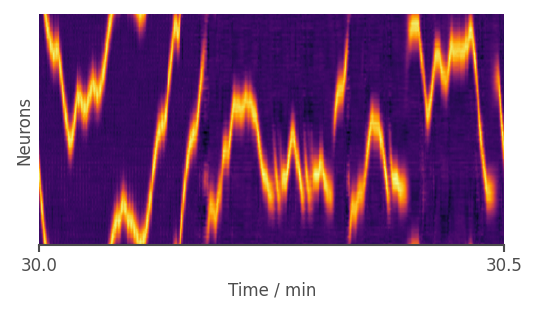

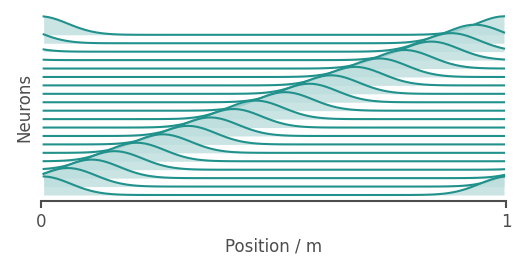

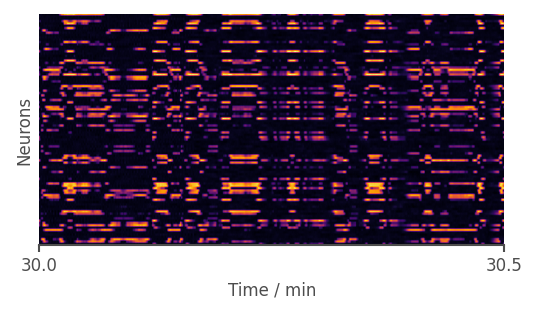

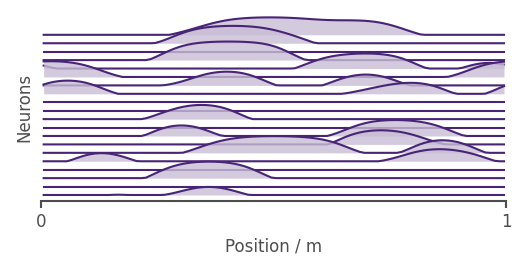

In [40]:
# here is the activity in HPC and EC before. You w
HPC.plot_rate_timeseries(t_start=Ag.t-30,imshow=True)
HPC.plot_rate_map(chosen_neurons='20')
EC.plot_rate_timeseries(t_start=Ag.t-30,imshow=True)
EC.plot_rate_map(chosen_neurons='20')

#### 3.2.2 Argsort by the peak of the MEC receptive fields 

In [41]:
#now we argsort (after plotting we put everything back as it was again to avoid confusion)
ratemaps = EC.basal_compartment.get_state(evaluate_at='all',theta=0)
argsort = np.argsort(np.argmax(ratemaps,axis=1))

#save copies of all weights to put things back later 
w_b = copy.deepcopy(EC.basal_compartment.inputs['HPC']['w'])
w_a = copy.deepcopy(EC.apical_compartment.inputs['EC']['w'])
wL_a = copy.deepcopy(EC.apical_compartment.inputs['CVCs']['w'][:,:EC.n])
wR_a = copy.deepcopy(EC.apical_compartment.inputs['CVCs']['w'][:,EC.n:])
fr = copy.deepcopy(EC.history['firingrate'])

#reorder basal weights and firing rates into MEC so plotting works 
EC.basal_compartment.inputs['HPC']['w'] = EC.basal_compartment.inputs['HPC']['w'][argsort]
EC.history['firingrate'] = np.array(EC.history['firingrate'])[:,argsort].tolist()

#also reorder the basal weights 
w_a_reorder = w_a[argsort][:,argsort]
wL_a_reorder = wL_a[argsort][:,argsort]
wR_a_reorder = wR_a[argsort][:,argsort]


#### 3.2.3 Visualise the population activity after reordering
 You should now see that MEC activity is structured -- this is because we have shuffled all the weights to order them BY definition. What you see is a bump of activity moving around the MEC population. This is the bump attractor. 

Figure saved to /Users/tomgeorge/Documents/UCL/HelmholtzHippocampus/NeurIPS_code/figures/13_12_23/EC_firingrate_1634_1.png  & .svg
Figure saved to /Users/tomgeorge/Documents/UCL/HelmholtzHippocampus/NeurIPS_code/figures/13_12_23/EC_ratemaps_1634_1.png  & .svg


(<Figure size 600x240 with 1 Axes>,
 <Axes: xlabel='Position / m', ylabel='Neurons'>)

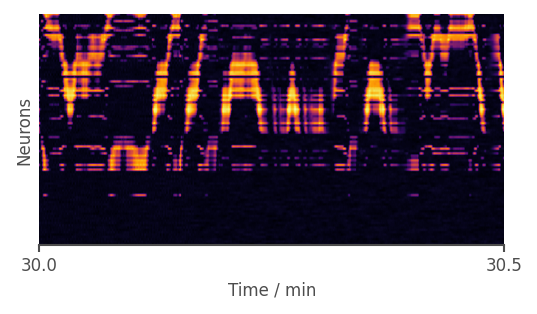

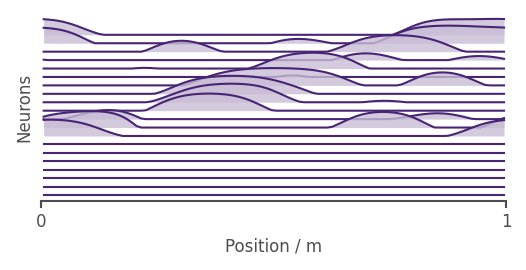

In [43]:
#plot
EC.plot_rate_timeseries(t_start=Ag.t-30,imshow=True)
EC.plot_rate_map(chosen_neurons='20')

#### 3.2.4 Plot the argsorted weights

This shows the weight matrices into the MEC apical copartments before and after reordering as well as aligned and averaged acrooss all the neurons 

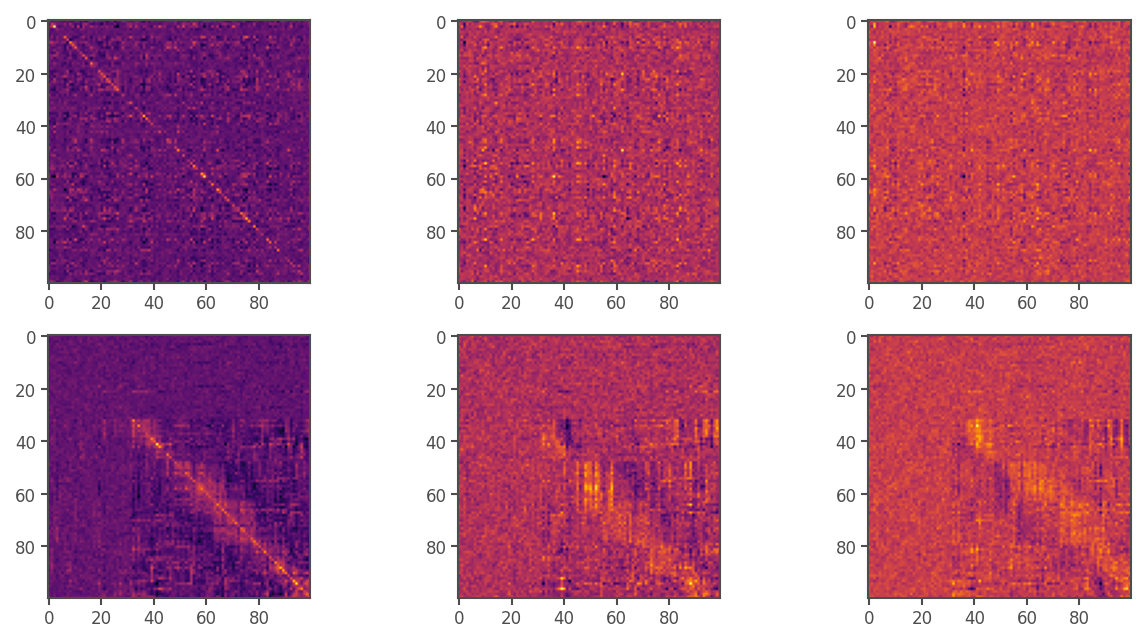

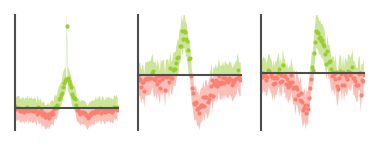

In [44]:
fig,ax = plt.subplots(2,3,figsize=(10,5))
ax[0,0].imshow(w_a)
ax[0,1].imshow(wL_a)
ax[0,2].imshow(wR_a)
ax[1,0].imshow(w_a_reorder)
ax[1,1].imshow(wL_a_reorder)
ax[1,2].imshow(wR_a_reorder)
fig, ax = plt.subplots(1,3,figsize=(3,1))
for (i,W) in enumerate((w_a_reorder,wL_a_reorder,wR_a_reorder)):
    W = align_matrix(W)
    x = np.arange(W.shape[1],) 
    W = np.mean(W,axis=0)
    Wstd = np.std(W,axis=0)
    ax[i].scatter(x[W>0],W[W>0],c='yellowgreen')
    ax[i].scatter(x[W<0],W[W<0],c='salmon')
    ax[i].fill_between(x,np.maximum(W+Wstd,0),np.maximum(W-Wstd,0),facecolor='yellowgreen',alpha=0.5)
    ax[i].fill_between(x,np.minimum(W+Wstd,0),np.minimum(W-Wstd,0),facecolor='salmon',alpha=0.5)
    tpl.xy_axes(ax[i])
    ax[i].set_yticks([])
    ax[i].set_xticks([])



#put back what we changed 
EC.history['firingrate'] = fr
EC.basal_compartment.inputs['HPC']['w'] = w_b

# I haven't tidied this but yet but will soon...

## 4 Remapping experiment
First we'll load in the Agent and layers that we saved after learning path integration up above (so we  don't have to retrain)

Now lets run a path integration test on the network before remapping

100%|██████████| 50/50 [00:36<00:00,  1.36it/s]


(80,) (80,) (80,)
Figure saved to /Users/tomgeorge/Documents/UCL/HelmholtzHippocampus/figures/24_05_23/pathint_1142.png  & .svg
Figure saved to /Users/tomgeorge/Documents/UCL/HelmholtzHippocampus/figures/24_05_23/decoding_1142.png  & .svg
Figure saved to /Users/tomgeorge/Documents/UCL/HelmholtzHippocampus/figures/24_05_23/error_1142.png  & .svg


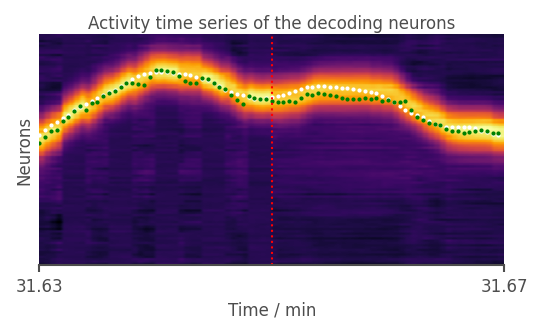

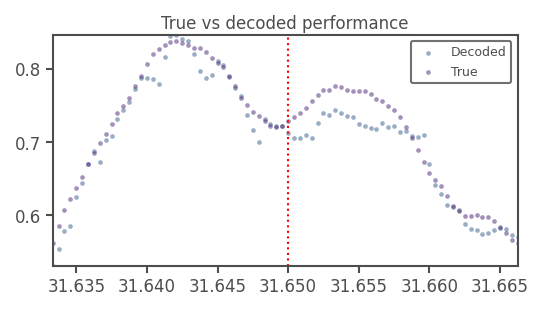

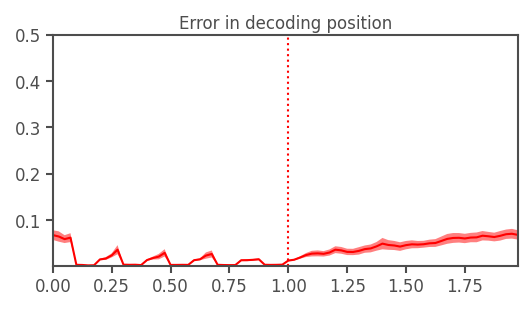

In [55]:
t, errors_init = run_pathint_test(layers, HPC, spin_up_secs=1, test_secs=1, n_tests=50, plot=True)

Figure saved to /Users/tomgeorge/Documents/UCL/HelmholtzHippocampus/figures/24_05_23/premapping_im_1151.png  & .svg
Figure saved to /Users/tomgeorge/Documents/UCL/HelmholtzHippocampus/figures/24_05_23/premapping_HPC_im_1151.png  & .svg


'../figures/24_05_23/premapping_HPC_im_1151'

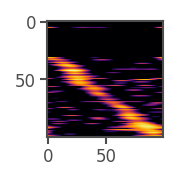

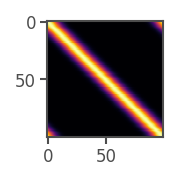

In [67]:
#before relearning, collect the ordering of the EC rate maps 
ratemaps = EC.basal_compartment.get_state(evaluate_at='all',theta=0)
argsort = np.argsort(np.argmax(ratemaps,axis=1))
fig, ax = plt.subplots()
ax.imshow(ratemaps[argsort])
tpl.save_figure(fig,"premapping_im")

ratemaps_HPC = HPC.basal_compartment.get_state(evaluate_at='all',theta=0)
argsort_HPC = np.argsort(np.argmax(ratemaps,axis=1))
fig, ax = plt.subplots()
ax.imshow(ratemaps_HPC)
tpl.save_figure(fig,"premapping_HPC_im")

now remap the features. The line plts show the new receptive fields of the sensroy input features and the imshows show the receptive fields of the MEC and HPC neurons (using the old ordering for MEC)


Figure saved to /Users/tomgeorge/Documents/UCL/HelmholtzHippocampus/figures/24_05_23/Features_ratemaps_1151.png  & .svg
Figure saved to /Users/tomgeorge/Documents/UCL/HelmholtzHippocampus/figures/24_05_23/Features_ratemaps_1151_1.png  & .svg
Figure saved to /Users/tomgeorge/Documents/UCL/HelmholtzHippocampus/figures/24_05_23/postremapping_im_1151.png  & .svg
Figure saved to /Users/tomgeorge/Documents/UCL/HelmholtzHippocampus/figures/24_05_23/postremapping_HPC_im_1151.png  & .svg


'../figures/24_05_23/postremapping_HPC_im_1151'

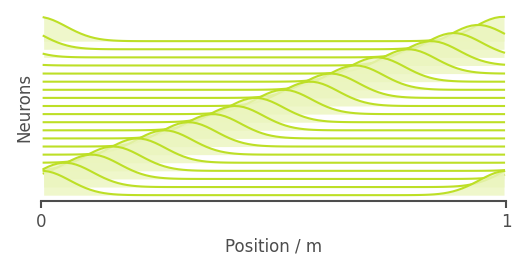

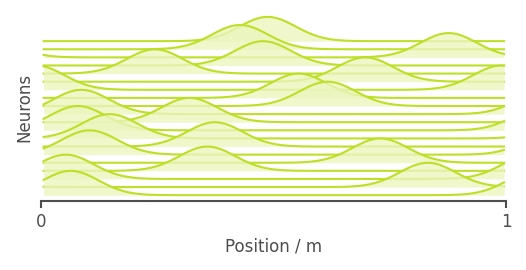

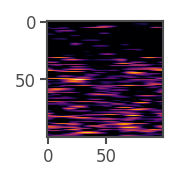

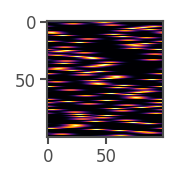

In [68]:
Features.plot_rate_map(chosen_neurons='20',route='basal',norm_by=1,overlap=3)
Features.remap()
Features.plot_rate_map(chosen_neurons='20',route='basal',norm_by=1,overlap=3)

ratemaps = EC.basal_compartment.get_state(evaluate_at='all',theta=0)
fig, ax = plt.subplots()
ax.imshow(ratemaps[argsort])
tpl.save_figure(fig,"postremapping_im")
ratemaps_HPC = HPC.basal_compartment.get_state(evaluate_at='all',theta=0)
fig, ax = plt.subplots()
ax.imshow(ratemaps_HPC)
tpl.save_figure(fig,"postremapping_HPC_im")

Optional. Now we run the agent for a further 10 minutes without learning. This is just to collect enough HPC data to retrain the decoder on the _new_ HPC receptive field. We only need to do this to test the decoding performance _just_ after remapping, so only do it if you really need to. 

<Loss> = [('HPC', '2.27e-01'), ('EC', '8.06e-02')]: 100%|██████████| 24000/24000 [00:37<00:00, 643.54it/s] 
100%|██████████| 50/50 [00:48<00:00,  1.04it/s]


(80,) (80,) (80,)
Figure saved to /Users/tomgeorge/Documents/UCL/HelmholtzHippocampus/figures/24_05_23/pathint_1144.png  & .svg
Figure saved to /Users/tomgeorge/Documents/UCL/HelmholtzHippocampus/figures/24_05_23/decoding_1144.png  & .svg
Figure saved to /Users/tomgeorge/Documents/UCL/HelmholtzHippocampus/figures/24_05_23/error_1144.png  & .svg


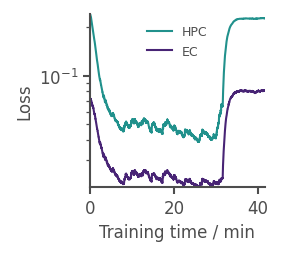

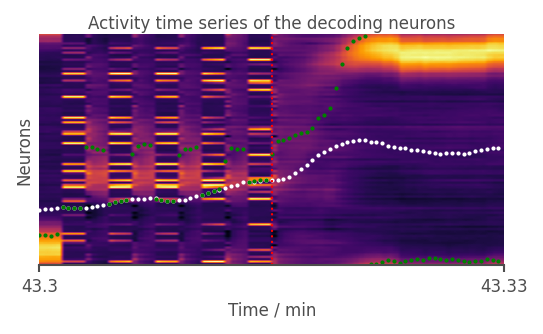

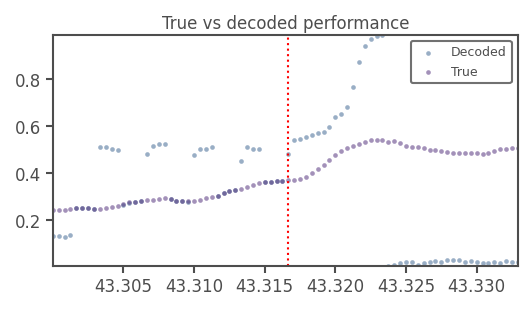

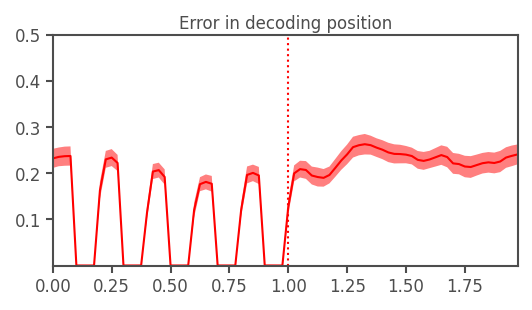

In [58]:
if True: 
    run_simulation(time_min=10,Agent=Ag,layers=layers,train=False,force_theta="constant_0")
    Ag.t_finished_training = Ag.t
    t, errors_after_remap = run_pathint_test(layers, HPC, spin_up_secs=1, test_secs=1, n_tests=50, plot=True)

If you ran the above cell (or the path integration test) now go and reload the Agent and layers again so this data doesn't sully the subsequent tests. 

Reload and reshuffle them again (so we can ignore the extra data we gained doing the above path int tests)
Now lets fix the weights within MEC by turing plasticity off.

Figure saved to /Users/tomgeorge/Documents/UCL/HelmholtzHippocampus/figures/24_05_23/Features_ratemaps_1144_2.png  & .svg
Figure saved to /Users/tomgeorge/Documents/UCL/HelmholtzHippocampus/figures/24_05_23/Features_ratemaps_1144_3.png  & .svg
Figure saved to /Users/tomgeorge/Documents/UCL/HelmholtzHippocampus/figures/24_05_23/premapping_postshuffle_im_1144.png  & .svg


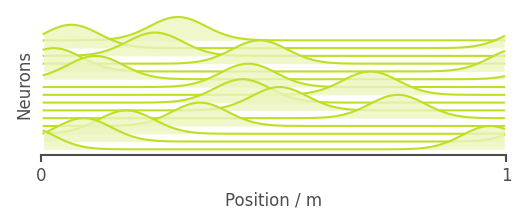

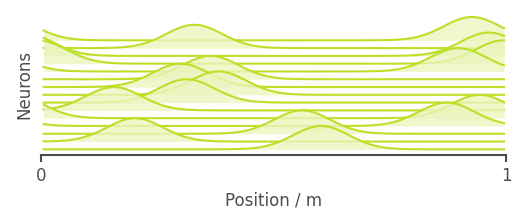

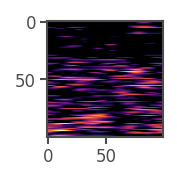

In [62]:
#REMAP
Features.plot_rate_map(chosen_neurons='15',route='basal',norm_by=1,overlap=3)
Features.remap()
Features.plot_rate_map(chosen_neurons='15',route='basal',norm_by=1,overlap=3)

#before relearning, collect the ordering of the EC rate maps 
ratemaps = EC.basal_compartment.get_state(evaluate_at='all',theta=0)
fig, ax = plt.subplots()
ax.imshow(ratemaps[argsort])
tpl.save_figure(fig,"premapping_postshuffle_im")

#FREEZE WEIGHTS
EC.apical_compartment.inputs['EC']['eta'] = 0.000
EC.apical_compartment.inputs['CVCs']['eta'] = 0.000
EC.basal_compartment.inputs['HPC']['eta'] = 0.01
HPC.apical_compartment.inputs['EC']['eta'] = 0.01

#RESET FIRING RATES 
EC.basal_compartment.firingrate = np.zeros(EC.n)
EC.apical_compartment.firingrate =  np.zeros(EC.n) 
HPC.basal_compartment.firingrate = np.zeros(HPC.n)
HPC.apical_compartment.firingrate =  np.zeros(HPC.n) 
HPC.firing_rate=0
EC.firing_rate=0

#It aids stability if we set a non-zero mean speed (I think it sort of breaks a symmetry in terms of how the bump attractor reforms)
Ag.speed_mean = 0.2

Now retrain for an additional 30 minutes 

<Loss> = [('HPC', '4.98e-02'), ('EC', '2.34e-02')]: 100%|██████████| 72000/72000 [03:44<00:00, 320.42it/s]


Figure saved to /Users/tomgeorge/Documents/UCL/HelmholtzHippocampus/figures/24_05_23/loss_1155.png  & .svg


'../figures/24_05_23/loss_1155'

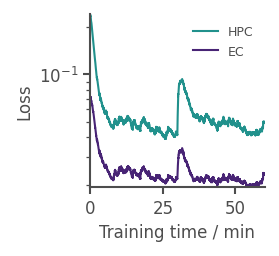

In [69]:
train_mins = 30
fig, ax = run_simulation(time_min=train_mins,Agent=Ag,layers=layers,train=True)
Ag.t_finished_training = Ag.t
tpl.save_figure(fig,"loss")

Figure saved to /Users/tomgeorge/Documents/UCL/HelmholtzHippocampus/figures/24_05_23/remapping_im_1149.png  & .svg
Figure saved to /Users/tomgeorge/Documents/UCL/HelmholtzHippocampus/figures/24_05_23/remapping_HPC_im_1149.png  & .svg


'../figures/24_05_23/remapping_HPC_im_1149'

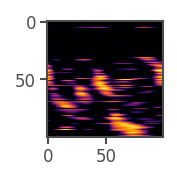

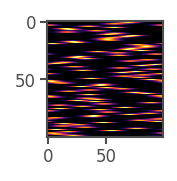

In [64]:
ratemaps = EC.basal_compartment.get_state(evaluate_at='all',theta=0)
# argsort_new = np.argsort(np.argmax(ratemaps,axis=1))
fig, ax = plt.subplots()
ax.imshow(ratemaps[argsort])
tpl.save_figure(fig,"remapping_im")

ratemaps_HPC = HPC.basal_compartment.get_state(evaluate_at='all',theta=0)
fig, ax = plt.subplots()
ax.imshow(ratemaps_HPC)
tpl.save_figure(fig,"remapping_HPC_im")

Finally do the last path integration test (after remapping after retraining)

100%|██████████| 50/50 [01:25<00:00,  1.70s/it]


(80,) (80,) (80,)
Figure saved to /Users/tomgeorge/Documents/UCL/HelmholtzHippocampus/figures/24_05_23/pathint_1151.png  & .svg
Figure saved to /Users/tomgeorge/Documents/UCL/HelmholtzHippocampus/figures/24_05_23/decoding_1151.png  & .svg
Figure saved to /Users/tomgeorge/Documents/UCL/HelmholtzHippocampus/figures/24_05_23/error_1151.png  & .svg


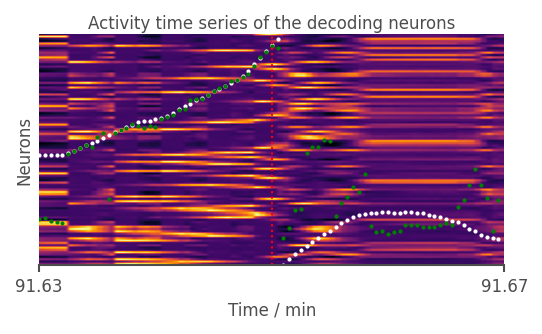

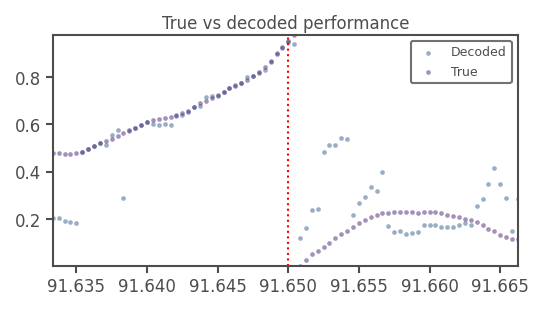

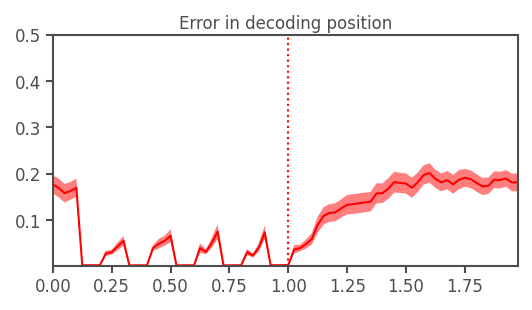

In [65]:
t, errors_after_retrain = run_pathint_test(layers, HPC, spin_up_secs=1, test_secs=1, n_tests=50, plot=True)

Make a bar chart showing PI error 1 second after

Figure saved to /Users/tomgeorge/Documents/UCL/HelmholtzHippocampus/figures/10_05_23/remapping_PI_errors_1525.png  & .svg


'../figures/10_05_23/remapping_PI_errors_1525'

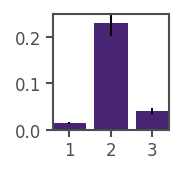

In [68]:
e1, s1 = np.mean(errors_init,axis=1)[-1], np.std(errors_init,axis=1)[-1]/np.sqrt(50)
e2, s2 = np.mean(errors_after_remap,axis=1)[-1], np.std(errors_after_remap,axis=1)[-1]/np.sqrt(50)
e3, s3 = np.mean(errors_after_retrain,axis=1)[-1], np.std(errors_after_retrain,axis=1)[-1]/np.sqrt(50)

fig, ax = plt.subplots()
ax.bar([1,2,3],[e1,e2,e3],yerr=[s1,s2,s3])
ax.set_ylim(top=0.25)
tpl.save_figure(fig,"remapping_PI_errors")